**The code provided is designed to detect pneumonia from chest X-ray images using a convolutional neural network (CNN) implemented in TensorFlow/Keras. It involves several steps: first, the dataset is loaded and augmented using ImageDataGenerator for better model generalization. The model architecture consists of convolutional layers, residual blocks, batch normalization, and dropout to prevent overfitting. This deep learning model is trained to classify images into either pneumonia or normal categories. After training, the model predicts the class of new X-ray images, and a visualization step plots the images with both the true and predicted labels, enabling easy evaluation of the model’s performance.**

In [4]:
#Import libraries
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Dropout, Dense, Flatten, Input, Add, GlobalAveragePooling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
import os

2024-08-18 16:56:51.957690: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-18 16:56:51.957785: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-18 16:56:52.088060: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### Load dataset

In [7]:
train_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/train'
val_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/val'
test_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/test'

In [9]:
total_classes = len(os.listdir(train_dir))
total_images = sum([len(files) for r, d, files in os.walk(train_dir)])

print(f"Total classes: {total_classes}")
print(f"Total number of images in training set: {total_images}")

Total classes: 2
Total number of images in training set: 5216


### Data preprocessing (dynamic augmentation)

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

test_generator = val_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Model design with Batch Normalization, Dropout, Residuals, and more layers


In [14]:
def residual_block(x, filters, kernel_size=3, strides=1):
    shortcut = x

    # If the number of filters is different, apply a 1x1 convolution to the shortcut
    if x.shape[-1] != filters:
        shortcut = Conv2D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    x = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = tf.keras.activations.relu(x)
    x = Conv2D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    x = Add()([shortcut, x])
    x = tf.keras.activations.relu(x)
    return x

In [15]:
input = Input(shape=(150, 150, 3))
x = Conv2D(64, (3, 3), padding='same', activation='relu')(input)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = residual_block(x, 64)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = residual_block(x, 128)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = residual_block(x, 256)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input, outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [29]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 150, 150,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 150, 150,  │        256 │ conv2d_5[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 75, 75,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 75, 75,    │     36,928 │ max_pooling2d_2[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_6[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 75, 75,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 75, 75,    │     36,928 │ re_lu_3[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 75, 75,    │        256 │ conv2d_7[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 75, 75,    │          0 │ max_pooling2d_2[… │
│                     │ 64)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_4 (ReLU)      │ (None, 75, 75,    │          0 │ add_2[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 37, 37,    │          0 │ re_lu_4[0][0]     │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 37, 37,    │     73,856 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 37, 37,    │        512 │ conv2d_9[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_5 (ReLU)      │ (None, 37, 37,    │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 37, 37,    │      8,320 │ max_pooling2d_3[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 37, 37,    │    147,584 │ re_lu_5[0][0]   

 Total params: 4,078,085 (15.56 MB)

 Trainable params: 1,358,465 (5.18 MB)

 Non-trainable params: 2,688 (10.50 KB)

 Optimizer params: 2,716,932 (10.36 MB)

In [19]:
# Callbacks for early stopping, learning rate reduction, and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
model_checkpoint = ModelCheckpoint('best_model.keras', save_best_only=True, monitor='val_accuracy', mode='max')

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=val_generator,
    validation_steps=val_generator.samples // val_generator.batch_size,
    epochs=20,  # Increased epochs
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 101s 589ms/step - accuracy: 0.8474 - loss: 0.3392 - val_accuracy: 0.5000 - val_loss: 6.3620 - learning_rate: 0.0010
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 6.3620 - learning_rate: 0.0010
Epoch 3/20


/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 71s 419ms/step - accuracy: 0.8834 - loss: 0.2576 - val_accuracy: 0.5000 - val_loss: 17.5284 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 17.5284 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 70s 413ms/step - accuracy: 0.8863 - loss: 0.2534 - val_accuracy: 0.5625 - val_loss: 0.9723 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5625 - val_loss: 0.9723 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 434ms/step - accuracy: 0.9111 - loss: 0.2157 - val_accuracy: 0.5000 - val_loss: 2.9801 - learning_rate: 0.0010
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 2.9801 - learning_rate: 0.0010
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 69s 405ms/step - accurac

In [23]:
# Load the best saved model
model.load_weights('best_model.keras')

### Evaluate model

In [24]:
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 8s 377ms/step - accuracy: 0.8402 - loss: 0.4343
Test Accuracy: 85.90%


### Sample image prediction and plotting (3x3 subplot)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step


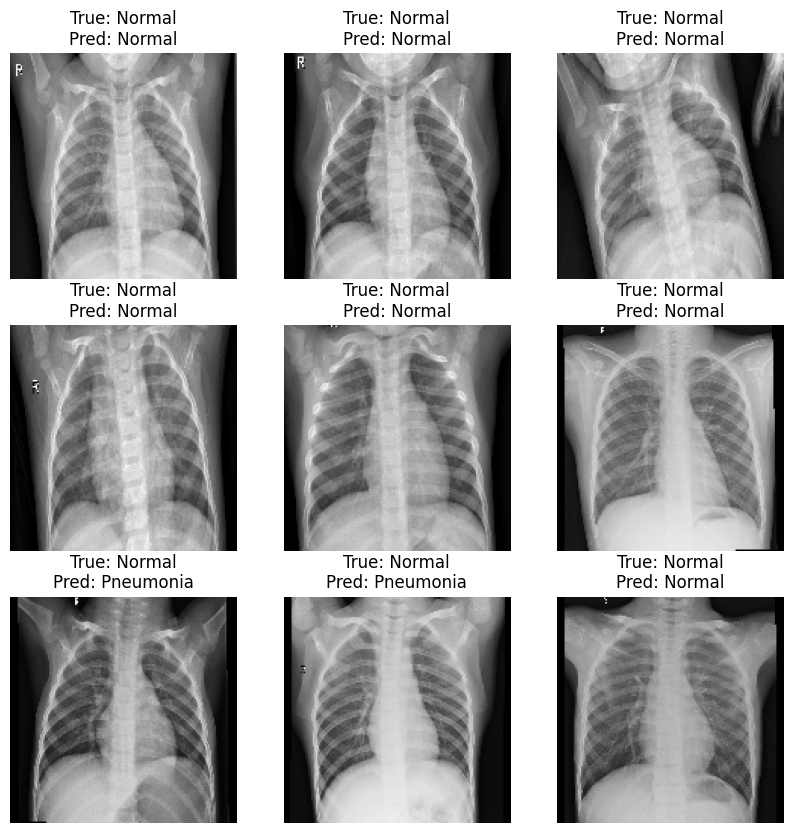

In [27]:
sample_images, sample_labels = next(test_generator)
predictions = model.predict(sample_images)

plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(sample_images[i])
    
    # Convert the predicted probability to a label (0 or 1)
    predicted_label = 'Pneumonia' if predictions[i] > 0.5 else 'Normal'
    
    # Convert the true label (0 or 1) to a human-readable label
    true_label = 'Pneumonia' if sample_labels[i] == 1 else 'Normal'
    
    plt.title(f"True: {true_label}\nPred: {predicted_label}")
    plt.axis('off')
plt.show()